<a href="https://www.kaggle.com/code/aahmedehab/ct-covid-99-5-test-acc?scriptVersionId=157337488" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import Model
from sklearn.metrics import classification_report , confusion_matrix

# get images from dataset files

In [2]:
positive = glob.glob('/kaggle/input/preprocessed-ct-scans-for-covid19/Original CT Scans/pCT/*.jpg')
nigative = glob.glob('/kaggle/input/preprocessed-ct-scans-for-covid19/Original CT Scans/nCT/*.jpg')
non_informative = glob.glob('/kaggle/input/preprocessed-ct-scans-for-covid19/Original CT Scans/NiCT/*.jpg')


random.shuffle(positive)
random.shuffle(nigative)
random.shuffle(non_informative)

train_positive = positive [:int (len (positive) *0.8)]
test_positive = positive[int (len (positive) *0.8):]

train_nigative =nigative [:int (len (nigative) *0.8)]
test_nigative = nigative[int (len (nigative) *0.8):]

train_non_informative = non_informative [:int (len (non_informative) *0.8)]
test_non_informative = non_informative[int (len (non_informative) *0.8):]

print ('number of train positive CT = {}'.format(len (train_positive)))
print ('number of train nigative CT = {}'.format(len (train_nigative)))
print ('number of train non informative CT = {}'.format(len (train_non_informative)))

print ('------------------------------------')

print ('number of test positive CT = {}'.format(len (test_positive)))
print ('number of test nigative CT = {}'.format(len (test_nigative)))
print ('number of test non informative CT = {}'.format(len (test_non_informative)))

number of train positive CT = 3200
number of train nigative CT = 7983
number of train non informative CT = 4564
------------------------------------
number of test positive CT = 801
number of test nigative CT = 1996
number of test non informative CT = 1141


# plot sample of each catogery

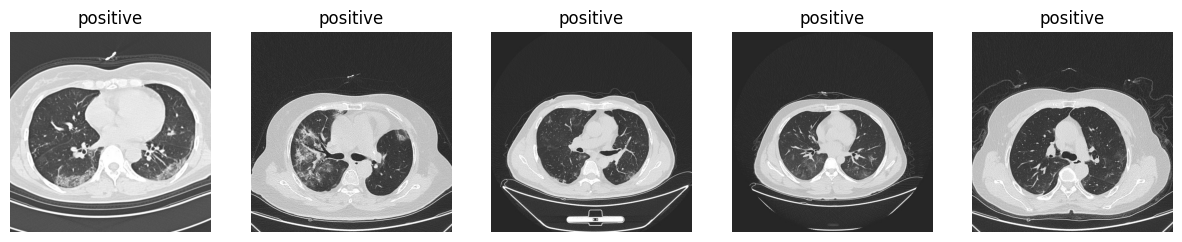

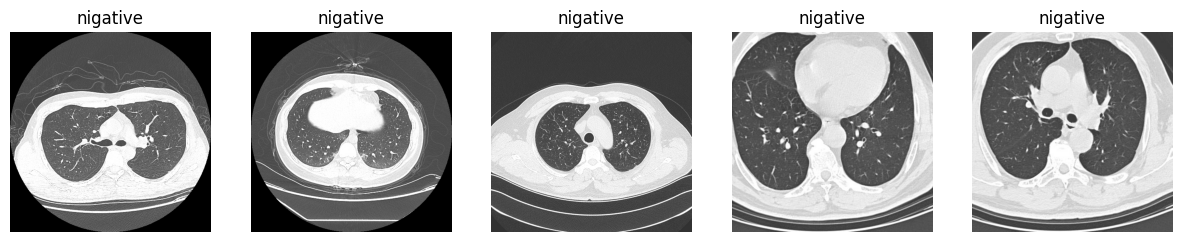

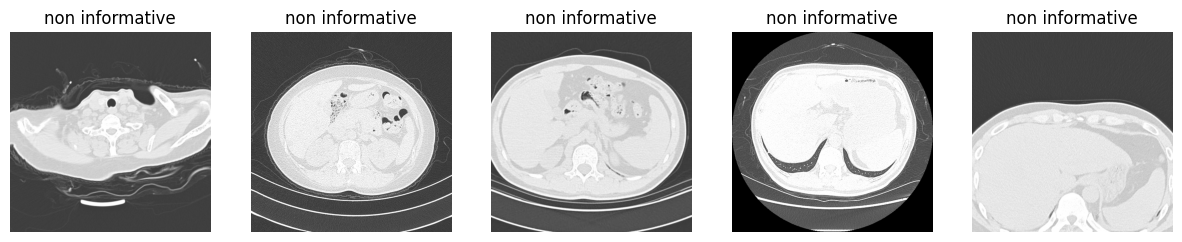

In [3]:
def plot_images (data ,image_title,num_of_images ,type_image = 'bgr'):
    plt.figure(figsize=(15,10))
    for i in range (num_of_images):
        random_image = random.choice(data)
        if type (data) == list:
            random_image = cv2.imread(random_image)
            
        if type_image.lower() == 'bgr':
            random_image =  cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(random_image)
        plt.axis('off')
        plt.title (image_title)
    
    plt.show()
non_informative
plot_images (train_positive ,'positive',5)
plot_images (train_nigative ,'nigative',5)
plot_images (train_non_informative ,'non informative',5)

# plot categories distribution

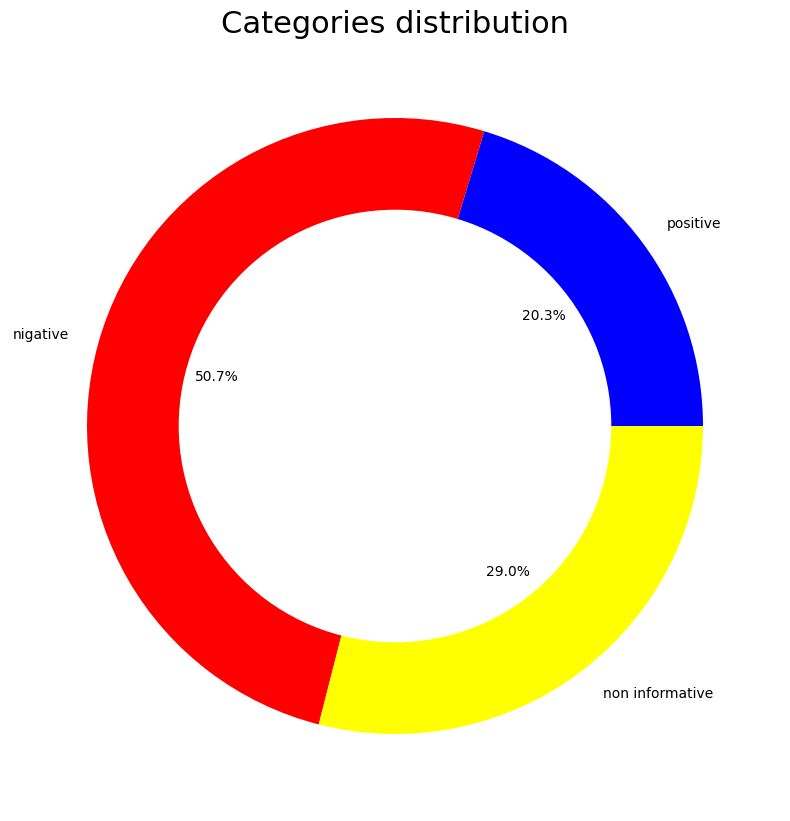

In [4]:
def plt_pie (data,labels,colors,title):
    plt.figure(figsize=(20,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(data,labels = labels, colors = colors , autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title (title,fontsize = 22)
    plt.show()
    
data = [len (train_positive) , len (train_nigative),len (train_non_informative) ]
labels = ['positive' , 'nigative' , 'non informative']
colors = ['blue','red','yellow']
plt_pie (data,labels,colors , 'Categories distribution')

# define functions to agumante image

In [5]:
def image_augmentation(low_data,target , p=0.5):
    
    images =[]
    
    albumentation_list = [A.RandomBrightness(limit = 0.5, p=p),A.RGBShift(p=p), A.RandomContrast(limit = 0.5,p =p) ,
                          A.Rotate(p=p, limit=40) , A.RandomCrop(p=p,height = 200, width = 200)]
    
    while (len (images) < target):
        for image in low_data:
            img = cv2.resize(cv2.imread(image), (256, 256) )
            operation = random.choice(albumentation_list)
            img = operation (image = img)['image']
            
            if img.shape[0] !=256:
                img = cv2.resize (img , (256, 256))
    
            images.append (img)
        
            if (len (images) >= target):
                break
    return np.array (images)

# convert link of images to images and resize it

In [6]:
def convert_links_to_images(data):
    images =[]
    for image in data:
        img = cv2.resize(cv2.imread(image), (256, 256) )
        images.append(img)
    return np.array (images)

# apply functions to agumante images and and balncing distribution of images

In [7]:
train_positive_images = image_augmentation(train_positive,8000,p=1)
train_negative_images = image_augmentation(train_nigative,8000,p=1)
train_non_informative_images = image_augmentation(train_non_informative,8000,p=1)

test_positive_images = convert_links_to_images(test_positive)
test_negative_images = convert_links_to_images(test_nigative)
test_non_informative_images = convert_links_to_images(test_non_informative)

# plot distribution of train data after balncing

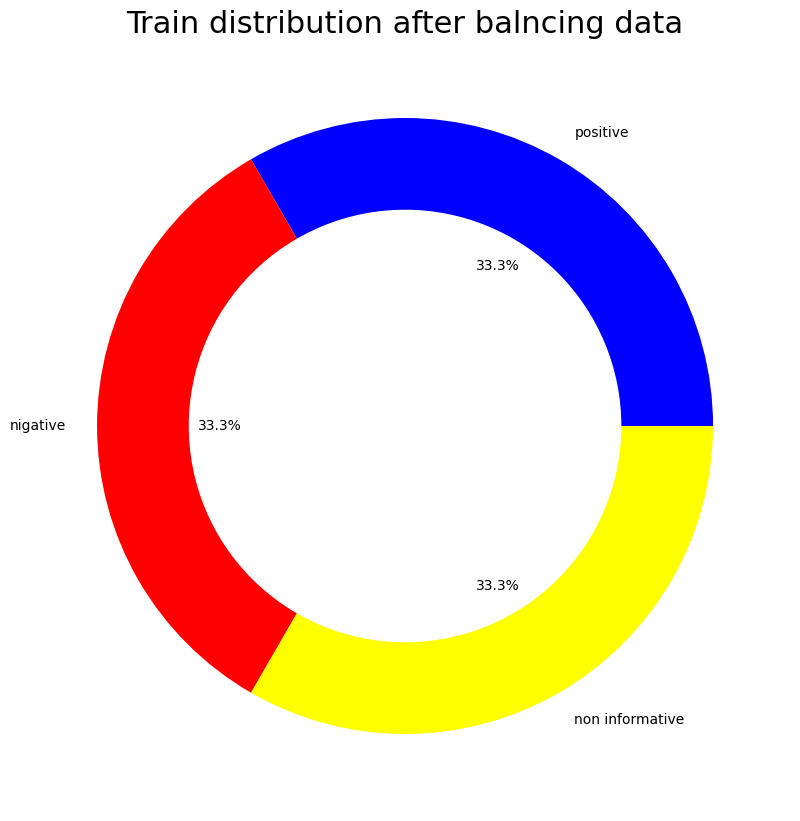

In [8]:
plt_pie ([len (train_positive_images) ,len (train_negative_images), len (train_non_informative_images)] ,labels,colors,'Train distribution after balncing data')

# plot sample from each category after preprocessing

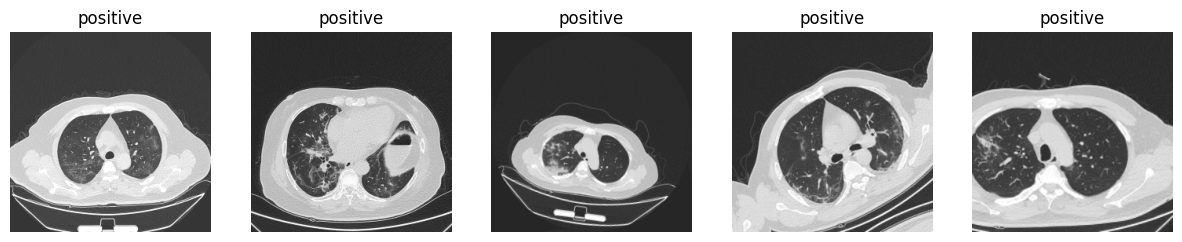

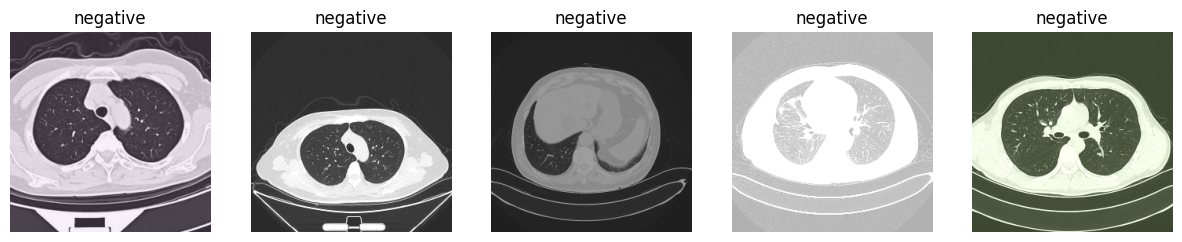

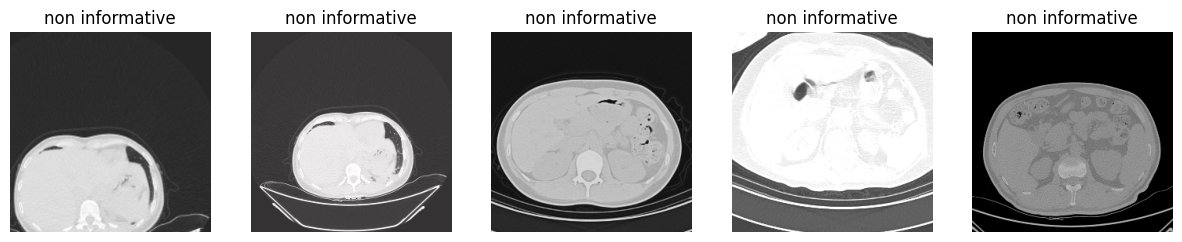

In [9]:
#Train data
plot_images (train_positive_images ,'positive',5)
plot_images (train_negative_images ,'negative',5)
plot_images (train_non_informative_images ,'non informative',5)

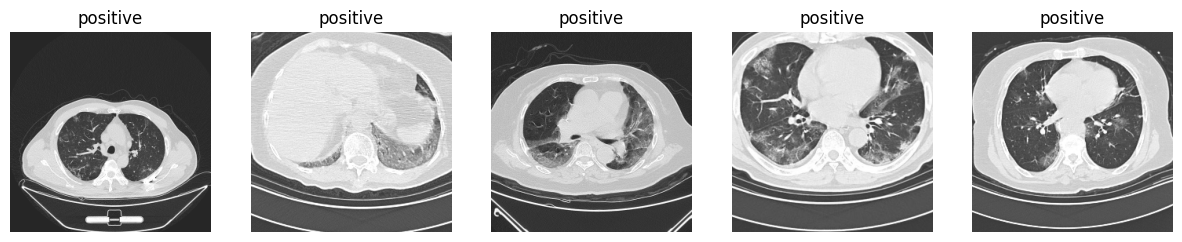

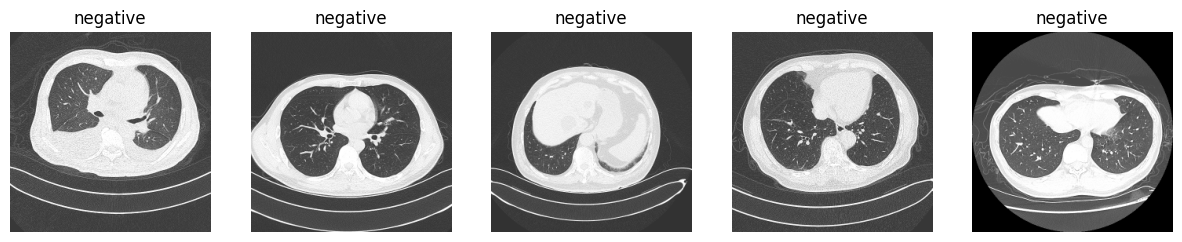

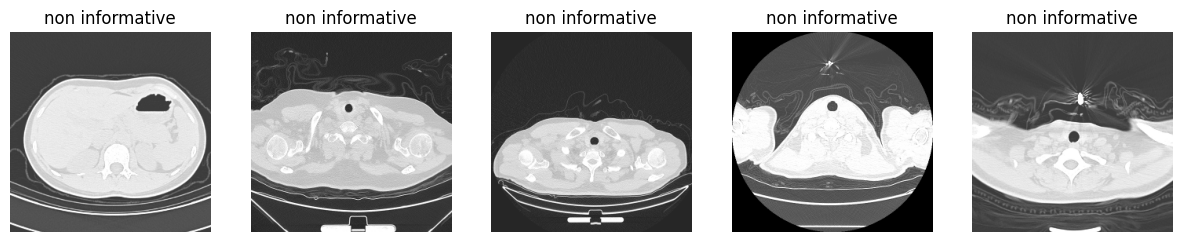

In [10]:
#Test data
plot_images (test_positive_images ,'positive',5)
plot_images (test_negative_images ,'negative',5)
plot_images (test_non_informative_images ,'non informative',5)

# get train and test data

In [11]:
y_train = np.concatenate ([np.zeros (len(train_positive_images)) , np.ones (len (train_negative_images)) , (np.ones (len (train_non_informative_images)) +1) ])
y_train = keras.utils.to_categorical (y_train)
X_train = np.concatenate ([train_positive_images,train_negative_images,train_non_informative_images],axis = 0)


y_test = np.concatenate ([np.zeros (len(test_positive_images)) , np.ones (len (test_negative_images)) , (np.ones (len (test_non_informative_images)) +1) ])
y_test = keras.utils.to_categorical (y_test)
X_test = np.concatenate ([test_positive_images,test_negative_images,test_non_informative_images],axis = 0)

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)
#--------------------------------free some memory--------------------------------
train_positive_images,train_negative_images,train_non_informative_images,test_positive_images,test_negative_images,test_non_informative_images = None,None,None,None,None,None
del train_positive_images,train_negative_images,test_positive_images,test_negative_images 

(24000, 256, 256, 3)
(24000, 3)
(3938, 256, 256, 3)
(3938, 3)


# create image datagenerator for train and test data

In [12]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255,)

train_generator = train_datagen.flow(X_train, y_train,batch_size=16,shuffle=True)
test_generator = test_datagen.flow(X_test, y_test,batch_size=16,shuffle=False)
#--------------------------------free some memory--------------------------------
X_train,y_train,X_test = None, None,None
del X_train,y_train,X_test

# get inception_v3 pre trained model

In [13]:
inception = keras.applications.inception_v3.InceptionV3 (input_shape = (256,256,3),
                                                            include_top = False,
                                                            weights = 'imagenet')
inception.trainable = False   

87910968/87910968 [==============================] - 0s 0us/step


# build full-model and fit model

In [14]:
last_output = inception.get_layer('mixed8').output 
x = Flatten()(last_output)
x = Dense(32, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=x)
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True,verbose = 1),
             ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]
            
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,epochs=100,validation_data=test_generator,callbacks=[callbacks])
model.load_weights('model.h5')

Epoch 1/100
1500/1500 [==============================] - 344s 218ms/step - loss: 0.2124 - accuracy: 0.9187 - val_loss: 0.1332 - val_accuracy: 0.9495
Epoch 2/100
1500/1500 [==============================] - 337s 225ms/step - loss: 0.1360 - accuracy: 0.9502 - val_loss: 0.1569 - val_accuracy: 0.9370
Epoch 3/100
1500/1500 [==============================] - 369s 246ms/step - loss: 0.1241 - accuracy: 0.9555 - val_loss: 0.0564 - val_accuracy: 0.9802
Epoch 4/100
1500/1500 [==============================] - 352s 235ms/step - loss: 0.1099 - accuracy: 0.9604 - val_loss: 0.0866 - val_accuracy: 0.9655
Epoch 5/100
1500/1500 [==============================] - 360s 240ms/step - loss: 0.1044 - accuracy: 0.9613 - val_loss: 0.1629 - val_accuracy: 0.9352
Epoch 6/100
1500/1500 [==============================] - 360s 240ms/step - loss: 0.0997 - accuracy: 0.9632 - val_loss: 0.0592 - val_accuracy: 0.9807
Epoch 7/100
1500/1500 [==============================] - 362s 241ms/step - loss: 0.0968 - accuracy: 0.9645

# plot loss and accuracy

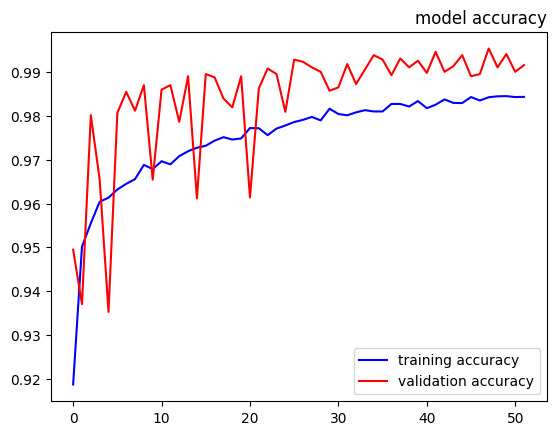

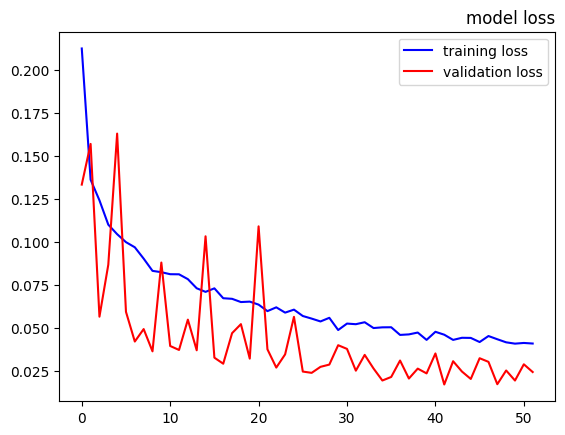

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss'] 
tarin_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range (len (tarin_acc)),tarin_acc,c='b',label = 'training accuracy')
plt.plot (range (len (val_acc)),val_acc,c='r',label = 'validation accuracy')
plt.title ('model accuracy',loc ='right')
plt.legend()
plt.show()

plt.plot(range (len (train_loss)),train_loss,c='b',label = 'training loss')
plt.plot (range (len (val_loss)),val_loss,c='r',label = 'validation loss')
plt.title ('model loss',loc ='right')
plt.legend()
plt.show()

# print confusion matrix and classification report

247/247 [==============================] - 10s 40ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       801
           1       1.00      1.00      1.00      1996
           2       0.99      0.99      0.99      1141

    accuracy                           0.99      3938
   macro avg       0.99      0.99      0.99      3938
weighted avg       0.99      0.99      0.99      3938



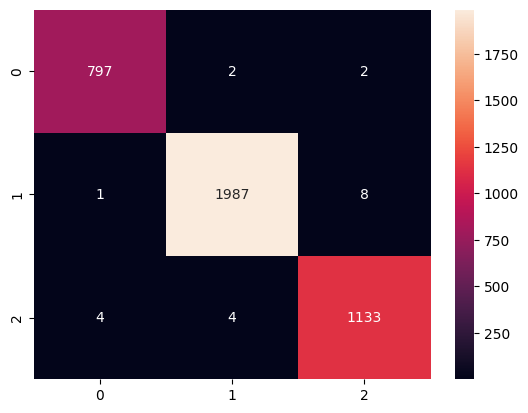

In [30]:
y_pred = np.round (model.predict (test_generator))
y_pred = np.argmax (y_pred,axis =1)
y_test = np.argmax (y_test,axis =1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt='d')
print (classification_report (y_test,y_pred))